# Drug Analysis

In this demo we will do a little exploration on medication cost. We will use the dataset from [Health Canada](https://www.canada.ca/en/health-canada/services/drugs-health-products/drug-products/drug-product-database.html) and formula data from British Columbia's [PharmaCare](https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/pharmacare/health-industry-professionals/downloadable-drug-data-files).

We will begin importing 3 dataframes from HC's Drug dataset. To keep this succinit I won't dig too much into the columns. Most of the information is found on their [ReadMe](https://www.canada.ca/en/health-canada/services/drugs-health-products/drug-products/drug-product-database/read-file-drug-product-database-data-extract.html). One thing to note is DRUG_CODE and DRUG_IDENTIFICATION_NUMBER are two different things. DRUG_CODE is the primary/foreign key that links all HC files together. However, the DRUG_IDENTIFICATION_NUMBER will become our primary/foreign key to join on once we introduce PharmaCare data.

We will begin by reading the 3 dataframes

In [1]:
# Import our libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load our csv. Please see the HC readme link for more info on the columns
drug_df = pd.read_csv('drug.txt', names=['DRUG_CODE', 'PRODUCT_VATEGORIZATION', 'CLASS', 
                                        'DRUG_IDENTIFICATION_NUMBER', 'BRAND_NAME', 'DESCRIPTOR', 
                                        'PEDIATRIC_FLAG', 'ACCESSION_NUMBER', 'NUMBER_OF_AIS', 'LAST_UPDATE_DATE', 
                                        'AI_GROUP_NO', 'CLASS_F', 'BRAND_NAME_F', 'DESCRIPTOR_F'])                                  

status_df = pd.read_csv('status.txt', names=['DRUG_CODE', 'CURRENT_STATUS_FLAG', 'STATUS', 
                                            'HISTORY_DATE', 'STATUS_F', 'LOT_NUMBER', 'EXPIRATION_DATE'])

therapeutics_df = pd.read_csv('ther.txt', names=['DRUG_CODE', 'TC_ATC_NUMBER', 'TC_ATC', 
                                                'TC_AHFS_NUMBER', 'TC_AHFS', 'TC_ATC_F', 'TC_AHFS_F'])

Lets take a quick peak of each the dataframes using the `head()` function.

In [2]:
drug_df.head()

,DRUG_CODE,PRODUCT_VATEGORIZATION,CLASS,DRUG_IDENTIFICATION_NUMBER,BRAND_NAME,DESCRIPTOR,PEDIATRIC_FLAG,ACCESSION_NUMBER,NUMBER_OF_AIS,LAST_UPDATE_DATE,AI_GROUP_NO,CLASS_F,BRAND_NAME_F,DESCRIPTOR_F
0,10000,NaN,Veterinary,813761,LINCOMIX,NaN,N,69580,1,03-DEC-2018,105826008,Vétérinaire,NaN,NaN
1,100000,CAT IV - SUNBURN PROTECTANTS,Human,2510804,COOLA CLASSIC FACE SPF 50 SUNSCREEN LOTION FRA...,NaN,N,NaN,4,22-JUL-2021,451521100,Humain,NaN,NaN
2,100001,CAT IV - SUNBURN PROTECTANTS,Human,2510812,COOLA CLASSIC FACE SPF 50 SUNSCREEN LOTION WHI...,NaN,N,NaN,4,22-JUL-2021,451521100,Humain,NaN,NaN
3,10001,NaN,Veterinary,813826,MGA 100 PREMIX,NaN,N,69581,1,15-AUG-2016,106337002,Vétérinaire,NaN,NaN
4,100012,NaN,Human,2510855,JAMP KETOROLAC,NaN,N,NaN,1,14-JUL-2021,121995001,Humain,NaN,NaN


In [3]:
status_df.head()

,DRUG_CODE,CURRENT_STATUS_FLAG,STATUS,HISTORY_DATE,STATUS_F,LOT_NUMBER,EXPIRATION_DATE
0,10000,N,APPROVED,02-MAR-2004,APPROUVÉ,NaN,NaN
1,10000,N,APPROVED,08-FEB-2018,APPROUVÉ,NaN,NaN
2,10000,N,APPROVED,15-MAY-1997,APPROUVÉ,NaN,NaN
3,10000,N,APPROVED,24-FEB-2004,APPROUVÉ,NaN,NaN
4,10000,N,APPROVED,27-JAN-2014,APPROUVÉ,NaN,NaN


In [4]:
therapeutics_df.head()

,DRUG_CODE,TC_ATC_NUMBER,TC_ATC,TC_AHFS_NUMBER,TC_AHFS,TC_ATC_F,TC_AHFS_F
0,18315,N02AA03,HYDROMORPHONE,28:08.08,OPIATE AGONISTS,NaN,NaN
1,18319,B05ZA,"HEMODIALYTICS, CONCENTRATES",40:34.00*,HEMODIALYSIS SOLUTION,NaN,NaN
2,18321,B05ZA,"HEMODIALYTICS, CONCENTRATES",40:34.00*,HEMODIALYSIS SOLUTION,NaN,NaN
3,18323,N02AA03,HYDROMORPHONE,28:08.08,OPIATE AGONISTS,NaN,NaN
4,19701,B05XA05,MAGNESIUM SULPHATE,28:12.92,MISCELLANEOUS ANTICONVULSANTS,NaN,NaN


These are a lot of columns in each file. We are not interested in most of them so I will filter some of the columns.

First we will drop all French translated columns. For the `drug_df` we will keep the DRUG_CODE, CLASS, DRUG_IDENTIFICATION_NUMBER, BRAND_NAME and AI_GROUP_NO for our analysis. We will then filter for only human drugs by keeping rows that have `Human` as their CLASS value. Then drop the CLASS column after as its no longer needed. For `status_df` we will keep only the English columns. Finally for `therapeutics_df` we will just focus on AHFS columns since they are more common nomenclature than ATC and keep only the English columns.

In [5]:
# Filter for the columns we are interested in
drug_df = drug_df[['DRUG_CODE', 'CLASS', 'DRUG_IDENTIFICATION_NUMBER', 'BRAND_NAME', 'AI_GROUP_NO']]

# Filter for only human drugs and drop the CLASS col after
drug_df = drug_df[drug_df['CLASS'] == 'Human']
drug_df.drop(columns=['CLASS'], inplace=True)

# Keep only english columns
status_df = status_df[['DRUG_CODE', 'CURRENT_STATUS_FLAG', 'STATUS', 'HISTORY_DATE', 'EXPIRATION_DATE']]

# lets keep just DRUG_CODE and AHFS Therapeutic groups
therapeutics_df = therapeutics_df[['DRUG_CODE', 'TC_AHFS_NUMBER', "TC_AHFS"]]

So now we must combine the datasets into one file. When combining we have to make sure the rows match up for their respective drug. We can achieve this by using an SQL style join. Luckly `pandas` provides the `merge()` method to do just that. Since all the files have the DRUG_CODE column, we will join based on that. An inner join is being used since we want to filter out any rows that don't have the complete information. 

Our `merge()` strategy as follows: We will merge `drug_df`, and `status_df` to create `drug_status_df`. Then we will merge `drug_status_df` and `therapeutics_df` to create the final dataframe, `drug_status_ther_df`.

In [6]:
# inner join the dataframes
drug_status_df = pd.merge(drug_df, status_df, on='DRUG_CODE', how='inner')
drug_status_ther_df = pd.merge(drug_status_df, therapeutics_df, on='DRUG_CODE', how='inner')

# lets see the first 5 rows
drug_status_ther_df.head()

,DRUG_CODE,DRUG_IDENTIFICATION_NUMBER,BRAND_NAME,AI_GROUP_NO,CURRENT_STATUS_FLAG,STATUS,HISTORY_DATE,EXPIRATION_DATE,TC_AHFS_NUMBER,TC_AHFS
0,100000,2510804,COOLA CLASSIC FACE SPF 50 SUNSCREEN LOTION FRA...,451521100,N,APPROVED,08-JAN-2021,NaN,84:80.00,SUNSCREEN AGENTS
1,100000,2510804,COOLA CLASSIC FACE SPF 50 SUNSCREEN LOTION FRA...,451521100,Y,MARKETED,31-MAR-2021,NaN,84:80.00,SUNSCREEN AGENTS
2,100001,2510812,COOLA CLASSIC FACE SPF 50 SUNSCREEN LOTION WHI...,451521100,N,APPROVED,08-JAN-2021,NaN,84:80.00,SUNSCREEN AGENTS
3,100001,2510812,COOLA CLASSIC FACE SPF 50 SUNSCREEN LOTION WHI...,451521100,Y,MARKETED,31-MAR-2021,NaN,84:80.00,SUNSCREEN AGENTS
4,100012,2510855,JAMP KETOROLAC,121995001,N,APPROVED,19-JAN-2021,NaN,28:08.04.92,OTHER NONSTEROIDAL ANTIIMFLAMMATORY AGENTS


The last thing we will do is remove all rows where the STATUS is `APPROVED`. We are only concerned with rows that have STATUS equal to `MARKETED` since those are the drugs that are actively being sold and used by patients in Canada. The next line shows how to do it with a mask filter.

In [21]:
# Using the mask filter to get only MARKETED drugs
drug_status_ther_df = drug_status_ther_df[drug_status_ther_df['STATUS'] == 'MARKETED']
drug_status_ther_df.head()

,DRUG_CODE,DRUG_IDENTIFICATION_NUMBER,BRAND_NAME,AI_GROUP_NO,CURRENT_STATUS_FLAG,STATUS,HISTORY_DATE,EXPIRATION_DATE,TC_AHFS_NUMBER,TC_AHFS
1,100000,2510804,COOLA CLASSIC FACE SPF 50 SUNSCREEN LOTION FRA...,451521100,Y,MARKETED,31-MAR-2021,NaN,84:80.00,SUNSCREEN AGENTS
3,100001,2510812,COOLA CLASSIC FACE SPF 50 SUNSCREEN LOTION WHI...,451521100,Y,MARKETED,31-MAR-2021,NaN,84:80.00,SUNSCREEN AGENTS
5,100012,2510855,JAMP KETOROLAC,121995001,Y,MARKETED,08-JUL-2021,NaN,28:08.04.92,OTHER NONSTEROIDAL ANTIIMFLAMMATORY AGENTS
7,100015,2510871,ORAL-B GUM THERAPY,106834010,Y,MARKETED,05-JUL-2021,NaN,52:28.00,MOUTHWASHES AND GARGLES
9,100016,2510898,HAND SANITIZER,104993016,Y,MARKETED,26-AUG-2021,NaN,84:04.92,MISCELLANEOUS LOCAL ANTI-INFECTIVES


The next step is to load the BC's PharmaCare fomulary data to get the pricing data. We are using BC's formulary and not Ontario's because BC has the better documentation. When we initially load the data, we see there a lot of columns to look through. However, after reading the documentation I have decided to focus on Max Price, LCA Price, RDP Price and DIN/PIN. The last column is important because we will do another inner join based on DIN to connect the BC fomulary with the HC dataset.

In [8]:
# Load the BC data
bc_df = pd.read_csv('pddf_2022_01_25.csv')

# Keep only the DIN, Max Price, LCA Price, and RDP Price 
bc_df = bc_df[['DIN/PIN', 'Max Price', 'LCA Price', 'RDP Price']]

# Merge with drug_status_ther_df
bc_priced_drug_status_ther_df = pd.merge(bc_df, drug_status_ther_df, left_on='DIN/PIN', right_on='DRUG_IDENTIFICATION_NUMBER', how='inner')

# show the first 5 rows
bc_priced_drug_status_ther_df.head()

,DIN/PIN,Max Price,LCA Price,RDP Price,DRUG_CODE,DRUG_IDENTIFICATION_NUMBER,BRAND_NAME,AI_GROUP_NO,CURRENT_STATUS_FLAG,STATUS,HISTORY_DATE,EXPIRATION_DATE,TC_AHFS_NUMBER,TC_AHFS
0,809,0.6055,0.0,NaN,793,809,ALCON TEARS 0.5%,108634001,N,APPROVED,02-JUN-2017,NaN,52:13.00*,ARTIFICIAL TEARS
1,809,0.6055,0.0,NaN,793,809,ALCON TEARS 0.5%,108634001,N,APPROVED,08-DEC-2021,NaN,52:13.00*,ARTIFICIAL TEARS
2,809,0.6055,0.0,NaN,793,809,ALCON TEARS 0.5%,108634001,N,APPROVED,17-OCT-2019,NaN,52:13.00*,ARTIFICIAL TEARS
3,809,0.6055,0.0,NaN,793,809,ALCON TEARS 0.5%,108634001,N,MARKETED,02-JUN-2017,NaN,52:13.00*,ARTIFICIAL TEARS
4,809,0.6055,0.0,NaN,793,809,ALCON TEARS 0.5%,108634001,N,MARKETED,17-OCT-2019,NaN,52:13.00*,ARTIFICIAL TEARS


All the data are now in one dataframe, therefore we can now proceed with some analysis . We will answer the question, which year saw the most expensive drug release? 

We can do this by first creating a new dataframe that only contains HISTORY_DATE, and Max Price. Since the HISTORY_DATE contains the year the medication entered the market, we can extract the year using a lambda function that splices the last 4 characters of HISTORY_DATE. This works because all the values in HISTORY_DATE are in DD-MMM-YYYY format. Next we will use the `groupby()` to group together the rows based on HISTORY_YEAR and then use `sum()` to get the total cost.

The final step would be to visualize the results. Since this dataset includes years back to the 1950s, I will only show the last 20 years (excluding 2022 since its too early).

C:\Users\Shannon\AppData\Local\Temp/ipykernel_3852/3480490996.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_per_year_df['HISTORY_YEAR'] = cost_per_year_df['HISTORY_DATE'].apply(lambda x: str(x)[-4:])


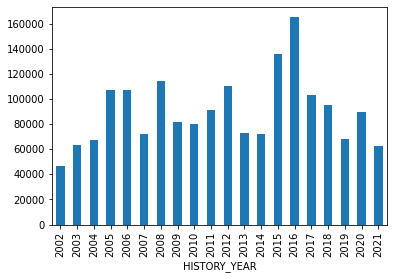

In [22]:
# Extract HISTORY_DATE and Max Price
cost_per_year_df = bc_priced_drug_status_ther_df[['HISTORY_DATE', 'Max Price']]

# Extract the HISTORY_YEAR from HISTORY_DATE using string splicing
cost_per_year_df['HISTORY_YEAR'] = cost_per_year_df['HISTORY_DATE'].apply(lambda x: str(x)[-4:])

# Group together based on HISTORY_YEAR and then find the sum
cost_per_year_df = cost_per_year_df.groupby('HISTORY_YEAR').sum()

# Isolate the last 20 years and show it as a bar graph 
last_20_years = cost_per_year_df.iloc[-21:-1]
last_20_years.plot.bar(legend=False)
plt.show()

We can see drug prices were low from 2002 to 2004. From 2005 and onwards prices started to increase. One thing to particularly to note is in 2016 drug prices skyrocked.

But why?

We can answer the question by using bc_priced_drug_status_ther_df and isolate only for drugs that gained MARKET status in 2016.

In [20]:
# Extract for year again
bc_priced_drug_status_ther_df['HISTORY_YEAR'] = bc_priced_drug_status_ther_df['HISTORY_DATE'].apply(lambda x: str(x)[-4:])
bc_priced_drug_status_ther_df[bc_priced_drug_status_ther_df['HISTORY_YEAR'] == '2016']['BRAND_NAME'].unique()

array(['SINEQUAN', 'FIORINAL-C 1/4', 'FIORINAL-C 1/2', 'VALISONE-G',
       'SANDOZ COLCHICINE', 'OVOL FOR GAS 80 MG TABLET',
       'CREO-RECTAL ENFANTS/CHILDREN', 'TEVA-CLOXACILLIN',
       'TEVA-HALOPERIDOL', 'APO-HYDRALAZINE', 'DEPAKENE', 'TIMOPTIC',
       'TOBRAMYCIN FOR INJECTION', 'VISKAZIDE', 'TINACTIN', 'EPIVAL',
       'RYTHMOL', 'RESTORIL', 'OTRIVIN MEDICATED COLD & ALLERGY RELIEF',
       'OPTIMYXIN', "MEN'S ROGAINE", 'ESTRAGYN VAGINAL CREAM',
       'DRIXORAL DECONGESTANT NASAL SPRAY',
       'WHITE PETROLEUM JELLY USP OINTMENT', 'SOOTHE ALLERGY',
       'PDP-DIPHENHYDRAMINE',
       'PDP-DIPHENHYDRAMINE EXTRA STRENGTH/ EXTRA FORT', 'SOOTHE REDNESS',
       '1.6% SODIUM CHLORDIE PROCESSING SOLUTION', 'ATENOLOL',
       'NEOCITRAN EXTRA STRENGTH COLD & CONGESTION',
       'CEFTAZIDIME FOR INJECTION, USP', 'CLOZARIL',
       'GAS-X EXTRA STRENGTH', 'LUVOX', 'DICETEL', 'BIAXIN BID',
       'ENTOCORT ENEMA', 'SANTYL', 'SORIATANE', 'TEVA-CYCLOBENZAPRINE',
       'BEZALIP SR', 

From the list, there were a few expensive drug such as Stelera, Repatha, and Revlimid (which is $10,000 for 28 days) that drove up the cost, but I also suspect that a lot of generics were released on to the market too. We can verify this claim with the same dataset at another time.